# Testing GNN Training

In [2]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

import torch
from torch_geometric.data import Data, DataLoader
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
import scipy as sp
import wandb

import warnings

warnings.filterwarnings("ignore")
sys.path.append("../../")
device = "cuda" if torch.cuda.is_available() else "cpu"

from models.submodels.agnn import GraphLevelAGNN

In [3]:
# load config
with open("attentiondeficit_config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [4]:
model = GraphLevelAGNN(config)

## Test Dataloading

In [5]:
model.setup(stage="fit")

Setting up dataset


In [6]:
sample = model.trainset[0]

In [7]:
sample

DataBatch(x=[94, 2], edge_index=[2, 347], y=[877], modulewise_true_edges=[83, 2], signal_true_edges=[83, 2], pt=[94], pid=[94], y_pid=[877], pid_signal=[877], y_trigger=[1], batch=[94], ptr=[2], max_attention=[877, 1])

In [6]:
for batch in model.train_dataloader():
    sample = batch.to(device)
    break

In [8]:
with torch.no_grad():
    model.eval()
    output, attention_log = model(sample.x, sample.edge_index, sample.batch, log_attention=True)

<AxesSubplot:ylabel='Density'>

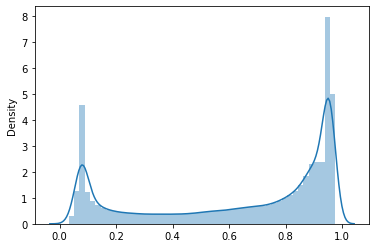

In [17]:
sns.distplot(torch.stack(attention_log).max(dim=0)[0].cpu().numpy())

<AxesSubplot:ylabel='Density'>

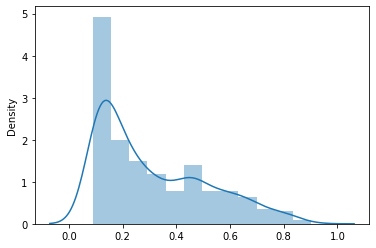

In [33]:
sns.distplot(sample.max_attention.cpu().numpy())

In [20]:
attention_cut = 0.9
stacked_attention = torch.stack(attention_log).max(dim=0)[0]

print(f"Number of edges passing cut: {stacked_attention[stacked_attention > attention_cut].shape[0]}, meaning {stacked_attention[stacked_attention > attention_cut].shape[0]/sample.x.shape[0]} edges per node")

Number of edges passing cut: 258664, meaning 28.31260945709282 edges per node


In [ ]:
top_dir = "/global/cfs/cdirs/m3443/data/TrackLRP/attention_cut_dir_1"
with torch.no_grad():
    model.eval()
    for dataset, dataname in zip([model.trainset, model.valset, model.testset], ["train", "val", "test"]):
        dataloader = DataLoader(dataset, batch_size=1, num_workers=0)
        save_dir = os.path.join(top_dir, dataname)
        os.makedirs(save_dir, exist_ok=True)
        for i, batch in enumerate(tqdm(dataloader)):
            sample = batch.to(device)
            output, attention_log = model(sample.x, sample.edge_index, sample.batch, log_attention=True)
            stacked_attention = torch.stack(attention_log).max(dim=0)[0]
            sample.max_attention = stacked_attention
            torch.save(sample.cpu(), os.path.join(save_dir, f"{i}.pt"))

100%|██████████| 1000/1000 [00:37<00:00, 26.60it/s]


In [ ]:
test_sample = torch.load(os.path.join(save_dir, "1.pt"))

In [ ]:
test_sample

DataBatch(x=[84, 2], edge_index=[2, 6463], y=[6463], modulewise_true_edges=[73, 2], signal_true_edges=[73, 2], pt=[84], pid=[84], y_pid=[6463], pid_signal=[6463], y_trigger=[1], batch=[84], ptr=[2], max_attention=[6463, 1])

In [41]:
test_sample.edge_index[:, test_sample.max_attention.squeeze() > 0.9].shape

torch.Size([2, 1470])

<AxesSubplot:ylabel='Count'>

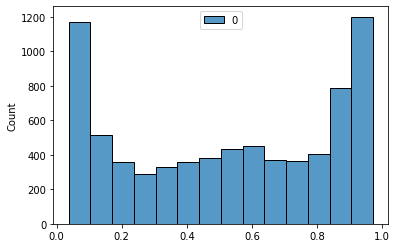

In [29]:
sns.histplot(test_sample.max_attention.numpy())